# 07_model_descriptive_statistics

## Build model and generate data

In [1]:
import numpy as np
import pyopencl as cl
import nengo
import nengo_ocl
from srnn_pfc.lmu import make_lmu_dms


In [2]:
srate = 1000
model_kwargs = {
    'n_trials_per_cond': 2,
    'seed': 1337,  # ensemble seed
    'trial_seed': 1337,
    'out_transform': None,
    'q': 6,
    'theta': 7.0,
    'tau': 0.2,  # Ignored if hetero_tau is True
    'n_neurons': 1200,
    'max_rates': ['default', 'uniform_low', 'data'][0],
    'dales_law': False,
    'hetero_tau': False,
    'ssp_dim': 0
}

# cl context
cl_plat = [_ for _ in cl.get_platforms() if _.vendor.upper().startswith('NVIDIA')][0]
cl_ctx = cl.Context(dev_type=cl.device_type.ALL,
                    properties=[(cl.context_properties.PLATFORM, cl_plat)])

# Generate training data
model, probes = make_lmu_dms(**model_kwargs)
n_train_trials = model_kwargs['n_trials_per_cond'] * 8 * 2  # 16 conditions
with nengo_ocl.Simulator(model, context=cl_ctx) as sim:
    sim.run(6 * n_train_trials)  # 6 seconds per trial
    
#filt = nengo.synapses.Lowpass(0.01)
filt = nengo.Alpha(0.05)
spikes = sim.data[probes['ensemble']]
rates = filt.filt(spikes)
tvec = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

c:\users\terry\documents\github\nengo\nengo\neurons.py:438: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Take a look at the spiketrains.

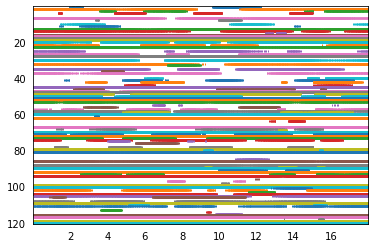

In [3]:
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import sorted_neurons, tuning_curves


sort_idx = sorted_neurons(model.ensembles[0], sim)
rasterplot(tvec[tvec < 18], spikes[:, sort_idx][tvec < 18, ::10])

## Calculate statistics of ensemble spiking

In [ ]:
import quantities as pq
from neo.core import SpikeTrain
from elephant.statistics import isi, cv, mean_firing_rate
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import spike_train_timescale
from pingouin import circ_corrcl


bin_size = 1 * pq.ms
max_tau = 500 * pq.ms
t_stop = (tvec[-1] + 0.001) * pq.s 
n_neur = model_kwargs['n_neurons']

cv_out = np.nan * np.ones((n_neur, 1))
rate_out = np.nan * np.ones((n_neur, 1))
tscale_out = np.nan * np.ones((n_neur, 1))

for n_ix in range(n_neur):
    spike_inds = np.where(spikes[:, n_ix])[0]
    if len(spike_inds) > 1:
        spike_times = tvec[spike_inds]
        spiketrain = SpikeTrain(spike_times * pq.s, t_stop)
        bin_spiketrain = BinnedSpikeTrain(spiketrain, bin_size=bin_size, t_stop=t_stop, tolerance=None)

        cv_out[n_ix] = cv(isi(spiketrain))
        rate_out[n_ix] = mean_firing_rate(spiketrain)
        tscale_out[n_ix] = spike_train_timescale(bin_spiketrain, max_tau).rescale(pq.s).magnitude


#### Distribution of CVs

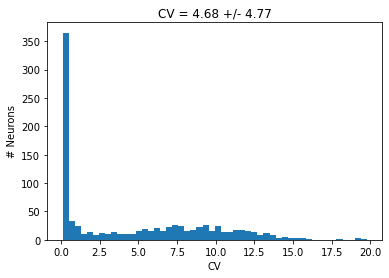

In [ ]:
tmp = cv_out[np.logical_and(~np.isnan(cv_out), cv_out > 0.1)]
plt.hist(tmp, bins=50)
plt.xlabel('CV')
plt.ylabel('# Neurons')
plt.title(f"CV = {np.nanmean(tmp):.2f} +/- {np.nanstd(tmp):.2f}")
plt.show()

#### Distribution of firing rates. (Note the log-scale in the plot.)

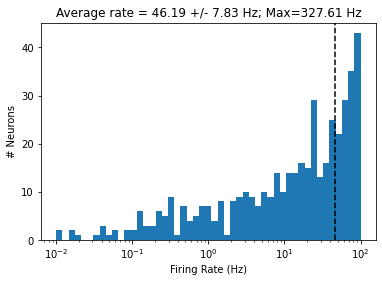

In [ ]:
avg_rate, sigma_rate = 10**np.nanmean(np.log10(rate_out)), 10**np.nanstd(np.log10(rate_out))

plt.hist(rate_out, bins=10 ** np.linspace(np.log10(0.01), np.log10(100), 50))
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('# Neurons')
plt.gca().set_xscale("log")
plt.axvline(avg_rate, ls='--', color='k')
plt.title(f"Average rate = {avg_rate:.2f} +/- {sigma_rate:.2f} Hz; Max={np.nanmax(rate_out):.2f} Hz")
plt.show()

#### Distribution of correlation timescales

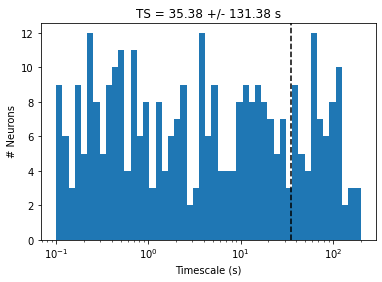

In [ ]:
tmp = np.sort(tscale_out[~np.isnan(tscale_out)])[::-1]
tmp = tmp[int(0.1 * tmp.size):int(0.9*tmp.size)]
plt.hist(tmp, bins=10 ** np.linspace(np.log10(0.1), np.log10(200), 50))
plt.xlabel('Timescale (s)')
plt.ylabel('# Neurons')
plt.gca().set_xscale("log")
plt.axvline(np.nanmean(tmp), ls='--', color='k')
plt.title(f"TS = {np.nanmean(tmp):.2f} +/- {np.nanstd(tmp):.2f} s")
plt.show()


## Tuning Curves

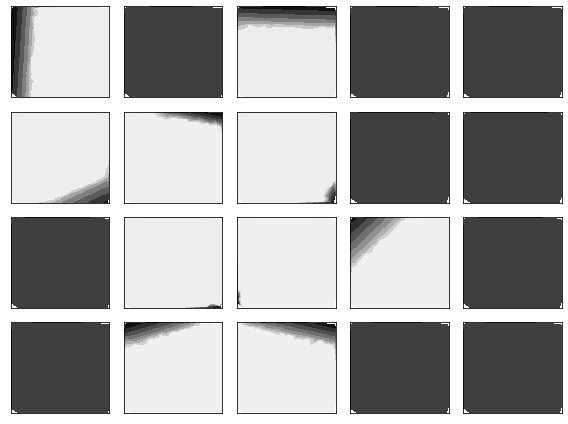

In [4]:
from srnn_pfc.lmu import make_ldn_B_A
ldn, B_full, A_full = make_ldn_B_A(theta=model_kwargs['theta'], q=model_kwargs['q'],
                                   size_in=2)

x = np.random.uniform(-1, 1, size=(500, 2))
x_converted, a = nengo.utils.ensemble.tuning_curves(model.ensembles[0], sim,
                                                    x @ B_full.T)

plt.figure(figsize=(8,6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.tricontourf(x[:,0], x[:,1], a[:,i], cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

The above method determines the tuning curves when there's no recurrent connection.  Let's try a different approach that will give tuning curves with the recurrence.

The idea is to run the model and just give a single pulse of input at the beginning, and then see what the response of the neurons are over time.  This is basically a peristimimulus time histogram.  We'll do this twice, once for each dimension of the input.  In theory, we could also do this for different combinations of this input, but the internal represenation is suppose to be at least approximately linear, so that shouldn't matter too much.


In [78]:
from srnn_pfc.lmu import make_ldn_B_A
ldn, B_full, A_full = make_ldn_B_A(theta=model_kwargs['theta'], q=model_kwargs['q'],
                                   size_in=2)

model2 = nengo.Network()

ens = model.ensembles[0]     # grab the ensemble out of the old model
model2.ensembles.append(ens) # and put it in the new one
model2.connections.append(model.connections[2])  # and include the recurrent connection
with model2:
    stim = nengo.Node(lambda t: [100,0] if 0<t<0.02 else [0,0])
    nengo.Connection(stim, ens, synapse=0.2, transform=B_full)
    p = nengo.Probe(ens.neurons)
sim = nengo.Simulator(model2)
with sim:
    sim.run(10.0)
data_dim1 = sim.data[p]

# now change the stimulus and run it again
stim.output = lambda t: [0,100] if 0<t<0.02 else [0,0]
sim = nengo.Simulator(model2)
with sim:
    sim.run(10.0)
data_dim2 = sim.data[p]


c:\users\terry\documents\github\nengo\nengo\neurons.py:438: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

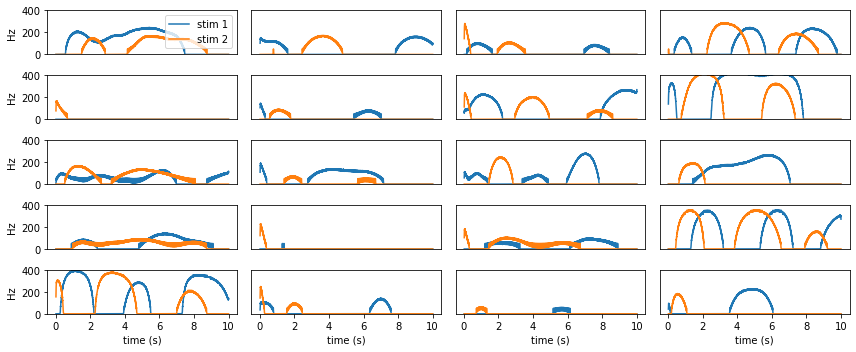

In [81]:
plt.figure(figsize=(12,5))
W = 4
H = 5
N = W*H

filt = nengo.synapses.Lowpass(0.01)  # just to smooth the spike data a bit, rather than binning it
start = 20
t = sim.trange()[start:]
for i in range(N):
    plt.subplot(H, W, i+1)
    plt.plot(t, filt.filtfilt(data_dim1[start:,i]), label='stim 1')
    plt.plot(t, filt.filtfilt(data_dim2[start:,i]), label='stim 2')
    if i == 0:
        plt.legend()
    if i<N-W:
        plt.xticks([])    
    else:
        plt.xlabel('time (s)')
    plt.ylim(0,400)
    if i%W == 0:
        plt.ylabel('Hz')
    else:
        plt.yticks([])
plt.tight_layout()
plt.show()

This shows the response of 20 different neurons, given just a pulse of input at the beginning.  The blue line is the response to a pulse on the first dimension of the input, and the orange line is the second dimension.  If it's given a pulse that's some combination of the two, it should give a response that's something like the combination of the two.  (It won't be a perfect sum, because of the neuron non-linearity, but it should be equivalent to adding the currents for the two cases).